## Import Dependencies and Data

In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("GPUs: ", gpus)

Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


c:\Users\bhavy\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ds = tfds.load('fashion_mnist', split='train')

In [5]:
ds.as_numpy_iterator().next().keys() # shows the format of the data

dict_keys(['image', 'label'])

## Building the Data Pipeline and Visualizing the Data

In [6]:
import numpy as np

In [7]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator() # creates an iterator object , it will go through the dataset one by one

In [8]:
dataiterator.next()['image'] 

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

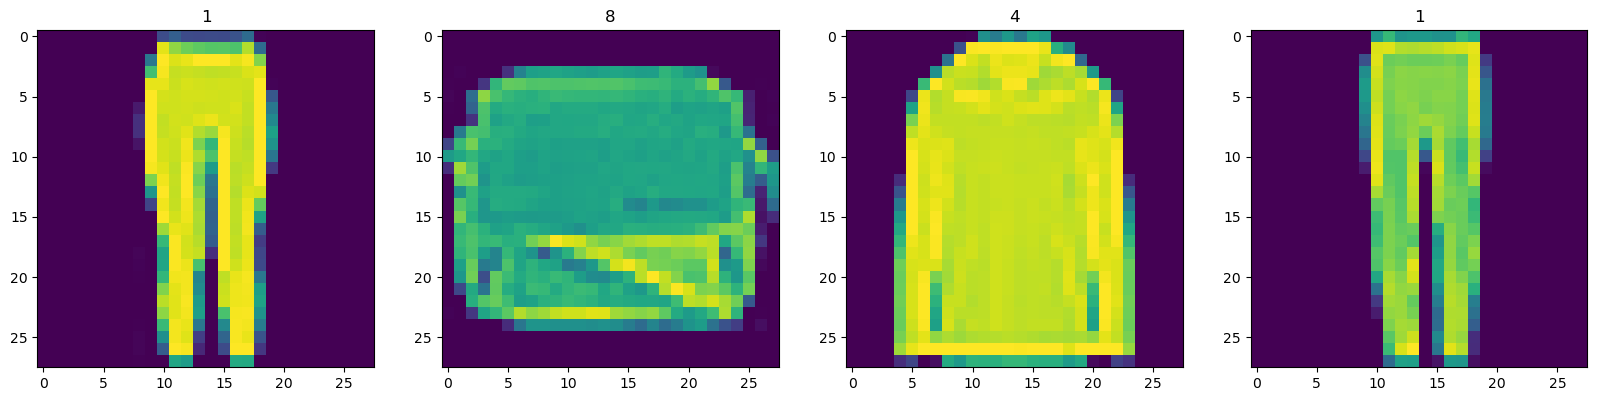

In [9]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get four images
for idx in range(4):  
    # Grab an image and label
    sample = dataiterator.next() # gets the next image in the dataset
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image'])) # it removes single-dimensional entries from the shape of an array i.e it converts (28,28,1) to (28,28)
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label']) # the label is a number from 0-9 representing the type of clothing

In [10]:
# Scale and return images only 
def scale_images(data): 
    image = data['image'] # grabs the image only
    return image / 255 # scales the image to be between 0 and 1 as oposed to 0-255

In [11]:
# Reload the dataset because we modified it earlier
ds = tfds.load('fashion_mnist', split='train') 
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch because it fits in memory and it will speed up training
ds = ds.cache()
# Shuffle it up to remove any order bias
ds = ds.shuffle(60000)
# Batch into 128 images per sample 
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking the GPU , prefetch 64 batches while the model is training on the current batch
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape # (128, 28, 28, 1) 128 images of 28x28 with 1 color channel

(128, 28, 28, 1)

## Build Neural Network

### Import Modelling Components

In [13]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### Build Generator

In [14]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128, random values are the noise that the generator will use to create images
    # Beginnings of a generated image created from random noise, random noise is a vector of 128 random values made by the random noise function in the training loop
    model.add(Dense(7*7*128, input_dim=128)) # first layer is a dense layer with 128 input nodes and 7*7*128 output nodes, dense means fully connected
    model.add(LeakyReLU(0.2)) # activation function, leaky relu allows a small gradient when the unit is not active, helps keep the weights updated and avoids dead neurons
    model.add(Reshape((7,7,128))) # reshapes the output to 7x7x128 beacause we will upsample it to 28x28 later
    
    # Upsampling block 1, unsampling means increasing the dimensions of the image to make it larger as it goes through the network
    model.add(UpSampling2D()) # doubles the size of the image from 7x7 to 14x14
    model.add(Conv2D(128, 5, padding='same')) # convolutional layer with 128 filters, kernel size of 5x5, padding same means the output size is the same as the input size
    # convolutional layer helps the model learn spatial hierarchies of features, helps the model learn patterns in the image in training data
    model.add(LeakyReLU(0.2)) # activation function
    
    # Upsampling block 2 , upsampling again to get to 28x28 , this is the final size of the image
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1 which will help refine the image , it will learn the patterns in the image and make it more realistic
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel because the images are grayscale so it only has one color channel to make it more realistic
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    # at the end we get a 28x28x1 image with values between 0 and 1 because of the sigmoid activation function, this is the final output of the generator
    # 28x28x1 is same as the input images in the dataset
    
    return model

In [15]:
generator = build_generator()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [17]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 0s 18ms/step


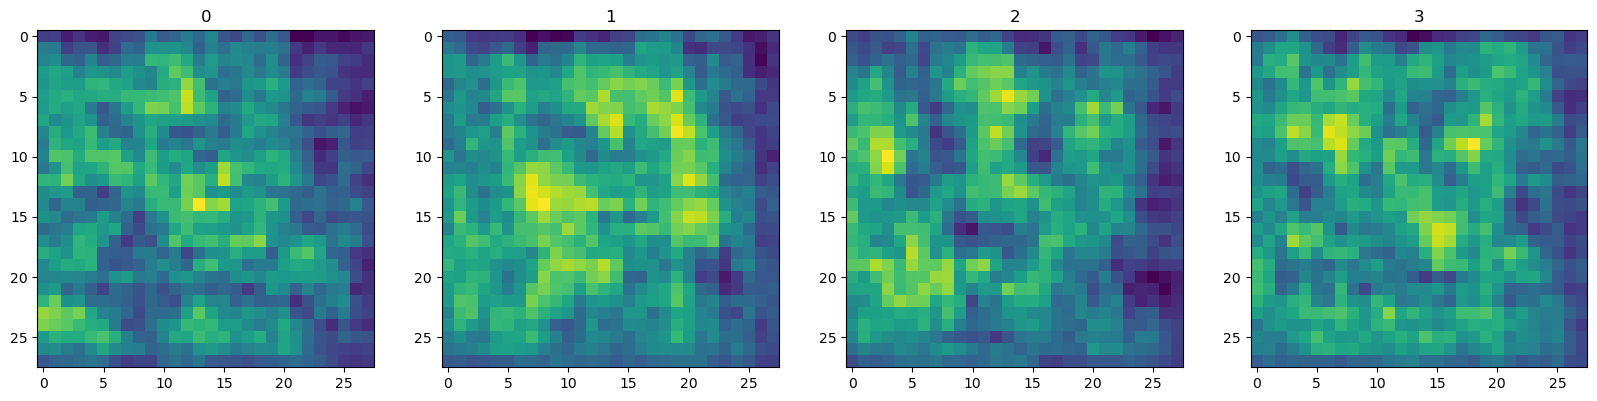

In [18]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)